# Activity and Shielding

In [204]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy.testing as npt
from operator import itemgetter, attrgetter
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
pd.options.display.float_format = '{:.2g}'.format

2017-12-17 10:23:21
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from math import sqrt, pi
from pynext.system_of_units import *
from pynext.Material import PhysicalMaterial
from pynext.Material import RadioactiveMaterial
from pynext.Material import PVMaterial
from pynext.Material import SelfAtt
from pynext.PhysicalVolume import PhysicalVolume
from pynext.Shapes import CylinderShell
from pynext.Shapes import Disk

In [3]:
from pynext.Material import vacuum, ti316, cu12, cu03, pb
from pynext.Material import GXe

In [179]:
from pynext.CylindricalVessel import CVD, CVA
from pynext.CylindricalVessel import CylindricalVessel

In [5]:
from collections import namedtuple

In [16]:
from pynext.NextData import NextPVData
from pynext.NextData import RFlux

## NEXT-100 PV dimensions

In [7]:
n100d = NextPVData()

In [8]:
n100d



        Next100PVData
        ------------------

        PV :
        inner diameter  = 1360.00 mm
        inner radius    =  680.00 mm
        outer diameter  = 1370.00 mm
        outer radius    =  685.00 mm
        body thickness  =   10.00 mm
        head thickness  =   12.00 mm
        length          = 1600.00 mm

        CS :
        inner diameter  = 1240.00 mm
        inner radius    =  620.00 mm
        outer diameter  = 1360.00 mm
        outer radius    =  680.00 mm
        body thickness  =  120.00 mm
        head thickness  =  120.00 mm
        length          = 1600.00 mm

        PB :
        inner diameter  = 1370.00 mm
        inner radius    =  685.00 mm
        outer diameter  = 1570.00 mm
        outer radius    =  785.00 mm
        body thickness  =  200.00 mm
        head thickness  =  200.00 mm
        length          = 1600.00 mm

    

### Cylindrical Vessel

A cylindrical vessel contains two physical volumes fille with the same material, one describing the body (e.g the cylinder itself) and the other describing the heads (the end-cups). 

In [211]:
cvd_pv = CVD(name    = 'Next100PV',
                 R       = n100d.pv_inner_radius,
                 th_body = n100d.pv_body_thickness,
                 L       = n100d.pv_length,
                 th_head = n100d.pv_head_thickness)

n100_pv = CylindricalVessel(name=cvd_pv.name, material=ti316, cvd=cvd_pv)

In [212]:
n100_pv


        Cylindrical Vessel:

        ----------------
        name      = Next100PV
        material  = 316ti

        specific activity of material:
        Bi-214    =    1.00 mBq/kg
        Tl-208    =    0.15 mBq/kg

        body:
        R         =  680.00 mm
        thickness =   10.00 mm
        length    = 1600.00 mm
        surface   = 6.84e+06 mm2
        volume    = 6.89e+07 mm3
        mass      =  541.96 kg
        activity Bi-214 =  541.96 mBq, self-shielded = 195.19 mBq
        activity Tl-208 =   81.29 mBq, self-shielded =  29.28 mBq
        transmittance   = 7.36e-01

        heads:
        thickness =   12.00 mm
        surface   = 2.91e+06 mm2
        volume    = 3.49e+07 mm3
        mass      =  274.38 kg
        activity Bi-214 =  137.19 mBq, self-shielded =  47.44 mBq
        activity Tl-208 =   20.58 mBq, self-shielded =   7.12 mBq
        transmittance   = 6.92e-01

        

## Gamma activity in Canfranc

In [17]:
lsc_gamma_flux = RFlux()
lsc_gamma_flux



        LSC2010
        ------------------

        U238  flux  =  550.00 mBq / cm2
        Th232 flux  =  360.00 mBq / cm2
        Bi214 flux  =    3.85 mBq / cm2
        Tl208 flux  =   49.14 mBq / cm2

    

## Attenuation provided by the lead castle

In [18]:
pbth = np.arange(0, 20, 0.1) * cm
T = np.array([pb.transmittance_at_qbb(l) for l in pbth]) 

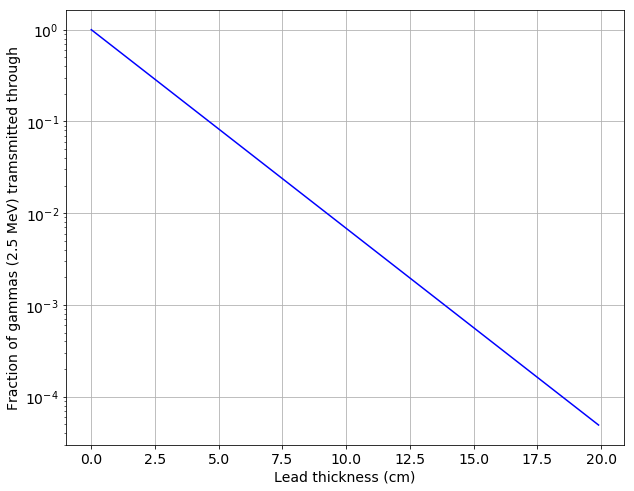

In [19]:
plt.semilogy(pbth / cm, T,'b')
plt.grid(True)
plt.xlabel('Lead thickness (cm)')
plt.ylabel('Fraction of gammas (2.5 MeV) tramsmitted through')
plt.show()

#### Lead shield reduce energetic gammas by four orders of magnitude

## Attenuation provided by copper shield

In [20]:
cuth = np.arange(0, 20, 0.1) * cm
T = np.array([cu12.transmittance_at_qbb(l) for l in cuth]) 

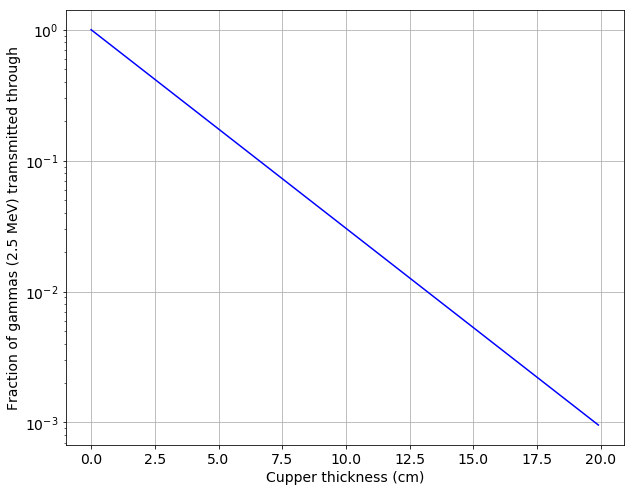

In [21]:
plt.semilogy(cuth / cm, T,'b')
plt.grid(True)
plt.xlabel('Cupper thickness (cm)')
plt.ylabel('Fraction of gammas (2.5 MeV) tramsmitted through')
plt.show()

#### Copper shielding provides ~2 orders of magnitude

## Unshielded flux from LSC crossing NEXT

1. Define a Cylindrical Vessel of NEXT-100 dimensions filled with vacuum (no self-shielding)
2. Compute the total activity entering the detector as the product of the surfaces of the envelop volumes and the LSC flux. 

In [184]:
def punit(val, unit):
    u = eval(unit)
    return "{:7.2f} {:s}".format(val / u, unit)

In [190]:
def activity_lsc_gammas_through_CV(name, cv, gamma_flux):
    """Returns the activity of gammas through a cylindrical vessel (cv)"""
         
    activity = CVA(name = name,
                     body_bi214 = gamma_flux.Bi214     * cv.body_surface,
                     head_bi214 = 2 * gamma_flux.Bi214 * cv.head_surface,
                     body_tl208 = gamma_flux.Tl208     * cv.body_surface,
                     head_tl208 = 2 * gamma_flux.Tl208 * cv.head_surface)
    
    return activity

In [186]:
def activity_gammas_transmitted_CV(name, cv, ia):
    """For a cylindrical vessel (cv) and an incoming activity (ia)
       compute the transmitted activity
       
       """
        
    activity = CVA(name = name,
                     body_bi214 = ia.body_bi214 * cv.body_transmittance,
                     head_bi214 = ia.head_bi214 * cv.body_transmittance,
                     body_tl208 = ia.body_tl208 * cv.body_transmittance,
                     head_tl208 = ia.head_tl208 * cv.body_transmittance)
                     
    return activity

In [200]:
def print_activity(act, unit='Bq'):
    
    print("""
    activity \t\t {}
    body  (Bi-214) \t {} 
    head  (Bi-214) \t {} 
    total (Bi-214) \t {} 
    body  (Tl-208) \t {} 
    head  (Tl-208) \t {} 
    total (Tl-208) \t {} 
""".format(act.name,
           punit(act.body_bi214,unit), punit(act.head_bi214,unit), 
           punit(act.body_bi214 + act.head_bi214, unit),
           punit(act.body_tl208,unit), punit(act.head_tl208,unit), 
           punit(act.body_tl208 + act.head_tl208,unit)))

In [208]:
def activity_of_cv(name, cv):
    """Returns the self-shielded activity emanating from a CV"""
    activity = CVA(name = name,
                     body_bi214 = cv.body_self_shield_activity_bi214,
                     head_bi214 = cv.head_self_shield_activity_bi214,
                     body_tl208 = cv.body_self_shield_activity_tl208,
                     head_tl208 = cv.head_self_shield_activity_tl208)
    return activity
    

In [177]:
def activity_table(activities):
    
    df = pd.DataFrame(activities, columns=activities[0]._fields)
    df2 = df[['name','body_bi214', 'head_bi214', 'body_tl208','head_tl208']].copy()
    names = [df2[column].name for column in df2]
    for name in names[1:]:
        df2[name] /= mBq
    return df2

In [182]:
n100_envelop = CylindricalVessel(name='Next100Envelop', material=vacuum, cvd=cvd_pv)
n100_envelop


        Cylindrical Vessel:

        ----------------
        name      = Next100PV
        material  = vacuum

        specific activity of material:
        Bi-214    =    0.00 mBq/kg
        Tl-208    =    0.00 mBq/kg

        body:
        R         =  680.00 mm
        thickness =   10.00 mm
        length    = 1600.00 mm
        surface   = 6.84e+06 mm2
        volume    = 6.89e+07 mm3
        mass      =    0.00 kg
        activity Bi-214 =    0.00 mBq, self-shielded =   0.00 mBq
        activity Tl-208 =    0.00 mBq, self-shielded =   0.00 mBq
        transmittance   = 1.00e+00

        heads:
        thickness =   12.00 mm
        surface   = 2.91e+06 mm2
        volume    = 3.49e+07 mm3
        mass      =    0.00 kg
        activity Bi-214 =    0.00 mBq, self-shielded =   0.00 mBq
        activity Tl-208 =    0.00 mBq, self-shielded =   0.00 mBq
        transmittance   = 1.00e+00

        

In [206]:
lsc_activity_next_100 = activity_lsc_gammas_through_CV('LSC activity ',
                                                       n100_envelop, lsc_gamma_flux)
print_activity(lsc_activity_next_100, unit='Bq')


    activity 		 LSC activity 
    body  (Bi-214) 	  263.19 Bq 
    head  (Bi-214) 	  111.86 Bq 
    total (Bi-214) 	  375.05 Bq 
    body  (Tl-208) 	 3359.26 Bq 
    head  (Tl-208) 	 1427.69 Bq 
    total (Tl-208) 	 4786.95 Bq 



## Shielding provided by the Lead Castle

1. Define a Cylindrical shell filled with PB with the thickness of the PB shield
2. Compute the transmittance through the shield.
3. Compute the self-shielded activity

In [45]:
cvd_pb = CVD(name    ='PBShield', 
             R       =  n100d.pb_inner_diameter, 
             th_body = n100d.pb_body_thickness, 
             L       = n100d.pb_length, 
             th_head = n100d.pb_head_thickness)

In [46]:
n100_pb = CylindricalVessel(name='Next100Pb', material=pb, cvd=cvd_pb)
n100_pb


        Cylindrical Vessel:

        ----------------
        name      = PBShield
        material  = Pb

        specific activity of material:
        Bi-214    =    0.37 mBq/kg
        Tl-208    =    0.07 mBq/kg

        body:
        R         = 1370.00 mm
        thickness =  200.00 mm
        length    = 1600.00 mm
        surface   = 1.38e+07 mm2
        volume    = 2.96e+09 mm3
        mass      = 33487.07 kg
        activity Bi-214 = 12390.21 mBq, self-shielded = 368.65 mBq
        activity Tl-208 = 2444.56 mBq, self-shielded =  72.73 mBq
        transmittance   = 4.68e-05

        heads:
        thickness =  200.00 mm
        surface   = 1.18e+07 mm2
        volume    = 2.36e+09 mm3
        mass      = 26722.74 kg
        activity Bi-214 = 4943.71 mBq, self-shielded = 157.83 mBq
        activity Tl-208 =  975.38 mBq, self-shielded =  31.14 mBq
        transmittance   = 4.68e-05

        

In [202]:
lsc_activity_transmitted_pb = activity_gammas_transmitted_CV('activity after Pb',n100_pb , lsc_activity_next_100)
print_activity(lsc_activity_transmitted_pb, unit='mBq')


    activity 		 activity after Pb
    body  (Bi-214) 	   12.31 mBq 
    head  (Bi-214) 	    5.23 mBq 
    total (Bi-214) 	   17.54 mBq 
    body  (Tl-208) 	  157.09 mBq 
    head  (Tl-208) 	   66.76 mBq 
    total (Tl-208) 	  223.86 mBq 



## Shielding provided by the ICS

In [48]:
cvd_cu = CVD(name    ='CUShield', 
             R       = n100d.cs_inner_diameter, 
             th_body = n100d.cs_body_thickness, 
             L       = n100d.cs_length, 
             th_head = n100d.cs_head_thickness)
cvd_cu

CVD(name='CUShield', R=1240.0, th_body=120.0, L=1600.0, th_head=120.0)

In [49]:
n100_cu = CylindricalVessel(name='Next100CU', material=cu12, cvd=cvd_cu)
n100_cu


        Cylindrical Vessel:

        ----------------
        name      = CUShield
        material  = CuUpperLimits

        specific activity of material:
        Bi-214    =    0.01 mBq/kg
        Tl-208    =    0.00 mBq/kg

        body:
        R         = 1240.00 mm
        thickness =  120.00 mm
        length    = 1600.00 mm
        surface   = 1.25e+07 mm2
        volume    = 1.57e+09 mm3
        mass      = 14051.82 kg
        activity Bi-214 =  168.62 mBq, self-shielded =  12.12 mBq
        activity Tl-208 =   19.67 mBq, self-shielded =   1.41 mBq
        transmittance   = 1.51e-02

        heads:
        thickness =  120.00 mm
        surface   = 9.66e+06 mm2
        volume    = 1.16e+09 mm3
        mass      = 10387.53 kg
        activity Bi-214 =   62.33 mBq, self-shielded =   4.70 mBq
        activity Tl-208 =    7.27 mBq, self-shielded =   0.55 mBq
        transmittance   = 1.51e-02

        

In [203]:
lsc_activity_transmitted_cu = activity_gammas_transmitted_CV('activity after Cu', n100_cu , lsc_activity_transmitted_pb)
print_activity(lsc_activity_transmitted_cu, unit='mBq')


    activity 		 activity after Cu
    body  (Bi-214) 	    0.19 mBq 
    head  (Bi-214) 	    0.08 mBq 
    total (Bi-214) 	    0.26 mBq 
    body  (Tl-208) 	    2.37 mBq 
    head  (Tl-208) 	    1.01 mBq 
    total (Tl-208) 	    3.38 mBq 



In [207]:
act =activity_table([lsc_activity_next_100, lsc_activity_transmitted_pb, lsc_activity_transmitted_cu])
print(act)

                name  body_bi214  head_bi214  body_tl208  head_tl208
0      LSC activity      2.6e+05     1.1e+05     3.4e+06     1.4e+06
1  activity after Pb          12         5.2     1.6e+02          67
2  activity after Cu        0.19       0.079         2.4           1


#### LSC activity after Pb and Cu shield is negligible. 

## Activity due to Lead shield

In [209]:
pb_activity = activity_of_cv('activity of Pb (ss)', n100_pb)
print_activity(pb_activity, unit='mBq')


    activity 		 activity of Pb (ss)
    body  (Bi-214) 	  368.65 mBq 
    head  (Bi-214) 	  157.83 mBq 
    total (Bi-214) 	  526.48 mBq 
    body  (Tl-208) 	   72.73 mBq 
    head  (Tl-208) 	   31.14 mBq 
    total (Tl-208) 	  103.87 mBq 



In [210]:
pb_activity_transmitted_cu = activity_gammas_transmitted_CV('PB activity after Cu', n100_cu , pb_activity)
print_activity(pb_activity_transmitted_cu, unit='mBq')


    activity 		 PB activity after Cu
    body  (Bi-214) 	    5.57 mBq 
    head  (Bi-214) 	    2.38 mBq 
    total (Bi-214) 	    7.95 mBq 
    body  (Tl-208) 	    1.10 mBq 
    head  (Tl-208) 	    0.47 mBq 
    total (Tl-208) 	    1.57 mBq 



## Activity due to PV

In [213]:
pv_activity = activity_of_cv('activity of PV (ss)', n100_pv)
print_activity(pv_activity, unit='mBq')


    activity 		 activity of PV (ss)
    body  (Bi-214) 	  195.19 mBq 
    head  (Bi-214) 	   47.44 mBq 
    total (Bi-214) 	  242.64 mBq 
    body  (Tl-208) 	   29.28 mBq 
    head  (Tl-208) 	    7.12 mBq 
    total (Tl-208) 	   36.40 mBq 



In [214]:
pv_activity_transmitted_cu = activity_gammas_transmitted_CV('PV activity after Cu', n100_cu , pv_activity)
print_activity(pv_activity_transmitted_cu, unit='mBq')


    activity 		 PV activity after Cu
    body  (Bi-214) 	    2.95 mBq 
    head  (Bi-214) 	    0.72 mBq 
    total (Bi-214) 	    3.66 mBq 
    body  (Tl-208) 	    0.44 mBq 
    head  (Tl-208) 	    0.11 mBq 
    total (Tl-208) 	    0.55 mBq 



## Activity due to CS

In [216]:
cs_activity = activity_of_cv('activity of CS (ss)', n100_cu)
print_activity(cs_activity, unit='mBq')


    activity 		 activity of CS (ss)
    body  (Bi-214) 	   12.12 mBq 
    head  (Bi-214) 	    4.70 mBq 
    total (Bi-214) 	   16.81 mBq 
    body  (Tl-208) 	    1.41 mBq 
    head  (Tl-208) 	    0.55 mBq 
    total (Tl-208) 	    1.96 mBq 



In [218]:
act2 =activity_table([pb_activity_transmitted_cu, pv_activity_transmitted_cu, cs_activity])
print(act2)

                   name  body_bi214  head_bi214  body_tl208  head_tl208
0  PB activity after Cu         5.6         2.4         1.1        0.47
1  PV activity after Cu         2.9        0.72        0.44        0.11
2   activity of CS (ss)          12         4.7         1.4        0.55


In [219]:
act

,name,body_bi214,head_bi214,body_tl208,head_tl208
0,LSC activity,2.6e+05,1.1e+05,3.4e+06,1.4e+06
1,activity after Pb,12,5.2,1.6e+02,67
2,activity after Cu,0.19,0.079,2.4,1


In [220]:
act2

,name,body_bi214,head_bi214,body_tl208,head_tl208
0,PB activity after Cu,5.6,2.4,1.1,0.47
1,PV activity after Cu,2.9,0.72,0.44,0.11
2,activity of CS (ss),12,4.7,1.4,0.55
